### Directory structure

In [9]:
import os

# Skip file extensions and folder names
SKIP_EXTENSIONS = {".jpg", ".png", ".mat", ".bmp", ".jpeg" ,".txt", ".db", ".gitsave", ".pth"}
SKIP_DIR_NAMES = {"__pycache__", ".ipynb_checkpoints"}

def print_tree(root_path, indent="", max_items=10):
    try:
        items = os.listdir(root_path)
    except PermissionError:
        print(indent + "Permission denied")
        return

    # Filter items
    filtered = []
    for item in sorted(items):
        full_path = os.path.join(root_path, item)
        if os.path.isdir(full_path):
            if item in SKIP_DIR_NAMES:
                continue
        else:
            _, ext = os.path.splitext(item)
            if ext.lower() in SKIP_EXTENSIONS:
                continue
        filtered.append(item)

    total_items = len(filtered)
    display_items = filtered[:max_items]

    for i, item in enumerate(display_items):
        full_path = os.path.join(root_path, item)
        is_last = (i == len(display_items) - 1)
        prefix = "└── " if is_last else "├── "
        print(indent + prefix + item)

        if os.path.isdir(full_path):
            new_indent = indent + ("    " if is_last else "│   ")
            print_tree(full_path, new_indent, max_items)

    if total_items > max_items:
        print(indent + "│   ...")

if __name__ == "__main__":
    root_directory = "." 
    print(root_directory)
    print_tree(root_directory)


.
├── UPAR.ipynb
├── data
│   ├── Market1501
│   │   ├── Market-1501-v15.09.15
│   │   ├── bounding_box_test
│   │   ├── bounding_box_train
│   │   ├── gt_bbox
│   │   ├── gt_query
│   │   └── query
│   ├── PA100k
│   │   ├── data
│   │   └── release_data
│   │       └── release_data
│   ├── PETA
│   │   └── PETA dataset
│   │       ├── 3DPeS
│   │       │   └── archive
│   │       ├── CAVIAR4REID
│   │       │   └── archive
│   │       ├── CUHK
│   │       │   └── archive
│   │       ├── GRID
│   │       │   └── archive
│   │       ├── MIT
│   │       │   └── archive
│   │       ├── PRID
│   │       │   └── archive
│   │       ├── SARC3D
│   │       │   └── archive
│   │       ├── TownCentre
│   │       │   └── archive
│   │       ├── VIPeR
│   │       │   └── archive
│   │       └── i-LID
│   │           └── archive
│   ├── PETA_ALL_UPAR_labels.csv
│   ├── RAP2
│   │   └── RAP_dataset
│   │       └── .gitsave
│   ├── dataset_all.pkl
│   └── dataset_all_merged.pkl
└── peta_fix.ipynb


In [1]:
import pandas as pd
import pickle
import numpy as np
from PIL import Image
from IPython.display import display
import math
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
with open("data/dataset_all_merged.pkl", "rb") as f:
    upar_data = pickle.load(f)

# Check the top-level keys
print(type(upar_data))
print(upar_data.keys())

<class 'dict'>
dict_keys(['description', 'reorder', 'root', 'image_name', 'label', 'attr_name', 'dataset_ids', 'partition', 'weight_train', 'weight_val', 'weight_trainval', 'weight_test'])


In [3]:
import pandas as pd
import numpy as np

# Extract core elements using dict-style access
image_names = upar_data['image_name']
labels = np.array(upar_data['label'])
attr_names = upar_data['attr_name']
partition = upar_data.get('partition', None)

# Build DataFrame
df_upar = pd.DataFrame(labels, columns=attr_names)
df_upar["image_name"] = image_names

# Only include partition if it exists
if partition is not None:
    df_upar["partition"] = partition
    cols = ["image_name", "partition"] + attr_names
else:
    cols = ["image_name"] + attr_names

df_upar = df_upar[cols]

# Show sample
df_upar.head()


,image_name,partition,Age-Young,Age-Adult,Age-Old,Gender-Female,Hair-Length-Short,Hair-Length-Long,Hair-Length-Bald,UpperBody-Length-Short,...,LowerBody-Color-White,LowerBody-Color-Yellow,LowerBody-Color-Other,LowerBody-Type-Trousers&Shorts,LowerBody-Type-Skirt&Dress,Accessory-Backpack,Accessory-Bag,Accessory-Glasses-Normal,Accessory-Glasses-Sun,Accessory-Hat
0,Market1501/bounding_box_train/0002_c1s1_000451...,NaN,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
1,Market1501/bounding_box_train/0002_c1s1_000551...,NaN,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,Market1501/bounding_box_train/0002_c1s1_000776...,NaN,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
3,Market1501/bounding_box_train/0002_c1s1_000801...,NaN,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,Market1501/bounding_box_train/0002_c1s1_069056...,NaN,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,1,0,0


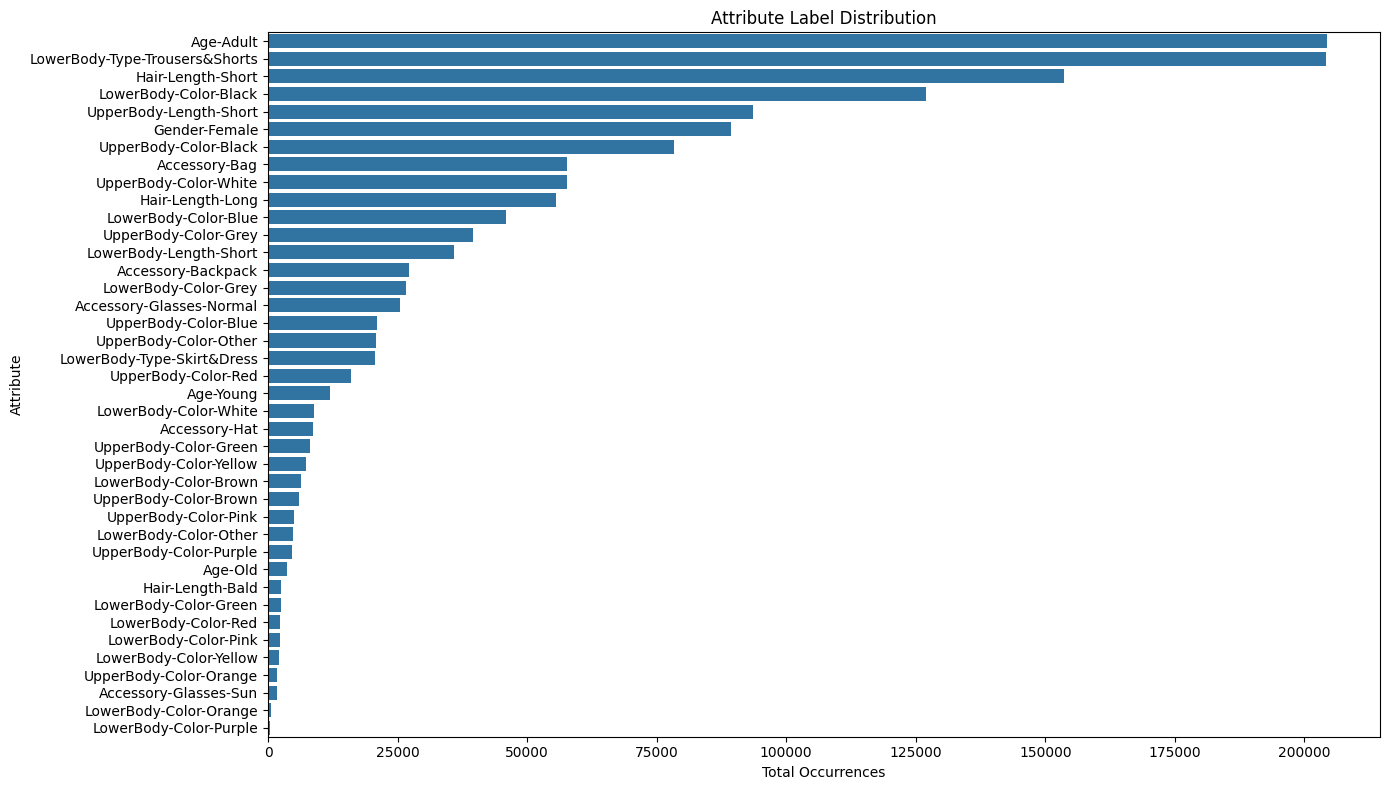

In [5]:
# Drop image name and partition to isolate labels
label_columns = df_upar.columns.difference(['image_name', 'partition'])

# Sum label occurrences
label_counts = df_upar[label_columns].sum().sort_values(ascending=False)

# Plot the distribution
plt.figure(figsize=(14, 8))
sns.barplot(x=label_counts.values, y=label_counts.index)
plt.title("Attribute Label Distribution")
plt.xlabel("Total Occurrences")
plt.ylabel("Attribute")
plt.tight_layout()
plt.show()


In [6]:
print("Top 5 Most Common Attributes:")
print(label_counts.head(5))

print(label_counts)


Top 5 Most Common Attributes:
Age-Adult                         204367
LowerBody-Type-Trousers&Shorts    204143
Hair-Length-Short                 153535
LowerBody-Color-Black             126884
UpperBody-Length-Short             93602
dtype: int64
Age-Adult                         204367
LowerBody-Type-Trousers&Shorts    204143
Hair-Length-Short                 153535
LowerBody-Color-Black             126884
UpperBody-Length-Short             93602
Gender-Female                      89325
UpperBody-Color-Black              78439
Accessory-Bag                      57739
UpperBody-Color-White              57610
Hair-Length-Long                   55557
LowerBody-Color-Blue               45936
UpperBody-Color-Grey               39530
LowerBody-Length-Short             35984
Accessory-Backpack                 27153
LowerBody-Color-Grey               26588
Accessory-Glasses-Normal           25464
UpperBody-Color-Blue               21105
UpperBody-Color-Other              20771
LowerBody-Type

### Explore label distributions

In [7]:
# Check unique values in each label column
for col in label_columns:
    unique_vals = df_upar[col].unique()
    if not set(unique_vals).issubset({0, 1}):
        print(f"{col} has non-binary values: {unique_vals}")


Gender-Female has non-binary values: [0 1 2]


### Explore label distributions

In [8]:
# Print unique values for each label column
for col in label_columns:
    unique_vals = sorted(df_upar[col].unique())
    print(f"{col}: {unique_vals}")


Accessory-Backpack: [0, 1]
Accessory-Bag: [0, 1]
Accessory-Glasses-Normal: [0, 1]
Accessory-Glasses-Sun: [0, 1]
Accessory-Hat: [0, 1]
Age-Adult: [0, 1]
Age-Old: [0, 1]
Age-Young: [0, 1]
Gender-Female: [0, 1, 2]
Hair-Length-Bald: [0, 1]
Hair-Length-Long: [0, 1]
Hair-Length-Short: [0, 1]
LowerBody-Color-Black: [0, 1]
LowerBody-Color-Blue: [0, 1]
LowerBody-Color-Brown: [0, 1]
LowerBody-Color-Green: [0, 1]
LowerBody-Color-Grey: [0, 1]
LowerBody-Color-Orange: [0, 1]
LowerBody-Color-Other: [0, 1]
LowerBody-Color-Pink: [0, 1]
LowerBody-Color-Purple: [0, 1]
LowerBody-Color-Red: [0, 1]
LowerBody-Color-White: [0, 1]
LowerBody-Color-Yellow: [0, 1]
LowerBody-Length-Short: [0, 1]
LowerBody-Type-Skirt&Dress: [0, 1]
LowerBody-Type-Trousers&Shorts: [0, 1]
UpperBody-Color-Black: [0, 1]
UpperBody-Color-Blue: [0, 1]
UpperBody-Color-Brown: [0, 1]
UpperBody-Color-Green: [0, 1]
UpperBody-Color-Grey: [0, 1]
UpperBody-Color-Orange: [0, 1]
UpperBody-Color-Other: [0, 1]
UpperBody-Color-Pink: [0, 1]
UpperBody-Co

In [9]:
df_upar = df_upar[df_upar["Gender-Female"] != 2]

In [10]:
# Find rows with Gender-Female == 2
invalid_gender = df_upar[df_upar["Gender-Female"] == 2]

# Count how many
print(f"Number of rows with Gender-Female == 2: {len(invalid_gender)}")

# Show some example image names
print("\nSample image names with Gender-Female == 2:")
print(invalid_gender["image_name"].head(10).to_list())


Number of rows with Gender-Female == 2: 0

Sample image names with Gender-Female == 2:
[]


### Explore label distributions

In [11]:
# Loop through each label column
for col in label_columns:
    counts = df_upar[col].value_counts().sort_index()
    present = counts.get(1, 0)
    absent = counts.get(0, 0)
    print(f"{col:30} Present: {present:<7} | Absent: {absent}")


Accessory-Backpack             Present: 27150   | Absent: 194511
Accessory-Bag                  Present: 57724   | Absent: 163937
Accessory-Glasses-Normal       Present: 25459   | Absent: 196202
Accessory-Glasses-Sun          Present: 1758    | Absent: 219903
Accessory-Hat                  Present: 8685    | Absent: 212976
Age-Adult                      Present: 204230  | Absent: 17431
Age-Old                        Present: 3757    | Absent: 217904
Age-Young                      Present: 12054   | Absent: 209607
Gender-Female                  Present: 89029   | Absent: 132632
Hair-Length-Bald               Present: 2461    | Absent: 219200
Hair-Length-Long               Present: 55550   | Absent: 166111
Hair-Length-Short              Present: 153394  | Absent: 68267
LowerBody-Color-Black          Present: 126803  | Absent: 94858
LowerBody-Color-Blue           Present: 45881   | Absent: 175780
LowerBody-Color-Brown          Present: 6346    | Absent: 215315
LowerBody-Color-Green       

### Explore label distributions

In [12]:
present_counts = []
absent_counts = []

for col in label_columns:
    counts = df_upar[col].value_counts().sort_index()
    present = counts.get(1, 0)
    absent = counts.get(0, 0)
    present_counts.append(present)
    absent_counts.append(absent)

binary_df = pd.DataFrame({
    "Attribute": label_columns,
    "Present (1)": present_counts,
    "Absent (0)": absent_counts
})

binary_df.set_index("Attribute", inplace=True)

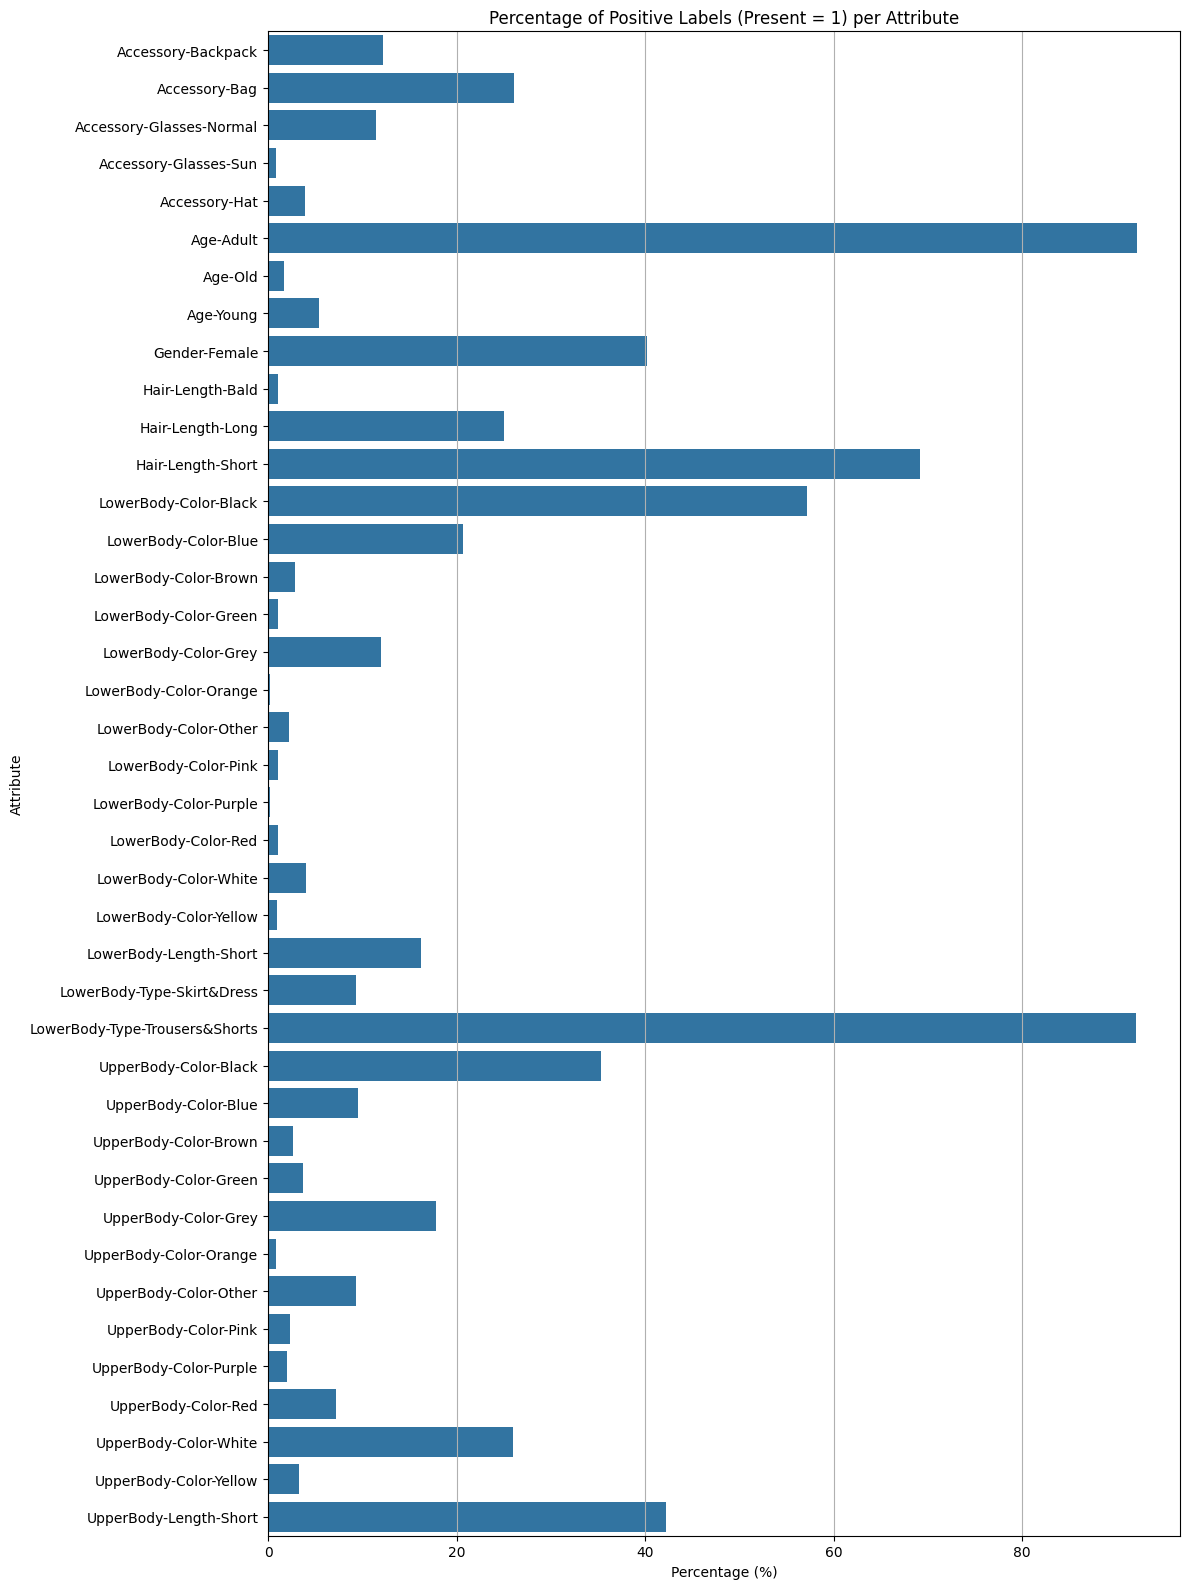

In [13]:
# Calculate and add Present %
binary_df["Present %"] = (binary_df["Present (1)"] / (binary_df["Present (1)"] + binary_df["Absent (0)"])) * 100

# Plot
plt.figure(figsize=(12, 16))
sns.barplot(x=binary_df["Present %"].values, y=binary_df.index)
plt.title("Percentage of Positive Labels (Present = 1) per Attribute")
plt.xlabel("Percentage (%)")
plt.ylabel("Attribute")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [14]:
# Define the threshold below which an attribute is considered "rare"
rare_threshold = 2  # means: less than 2% of samples have label = 1

# Calculate how frequent each attribute is
rare_attrs = binary_df[binary_df["Present %"] < rare_threshold].sort_values("Present %")

# Filter rare attributes
rare_attrs = binary_df[binary_df["Present %"] < rare_threshold]

# Explanation before output
print(f"\n--- Analysis of Label Imbalance ---")
print(f"Any attribute where less than {rare_threshold}% of the data has label = 1")
print("is considered very rare and may cause poor training performance.")
print("These attributes could be dropped.\n")

# Display results
print(f"Attributes with less than {rare_threshold}% positive labels:\n")
print(rare_attrs[["Present (1)", "Absent (0)", "Present %"]])



--- Analysis of Label Imbalance ---
Any attribute where less than 2% of the data has label = 1
is considered very rare and may cause poor training performance.
These attributes could be dropped.

Attributes with less than 2% positive labels:

                        Present (1)  Absent (0)  Present %
Attribute                                                 
Accessory-Glasses-Sun          1758      219903   0.793103
Age-Old                        3757      217904   1.694931
Hair-Length-Bald               2461      219200   1.110254
LowerBody-Color-Green          2454      219207   1.107096
LowerBody-Color-Orange          547      221114   0.246773
LowerBody-Color-Pink           2371      219290   1.069651
LowerBody-Color-Purple          443      221218   0.199855
LowerBody-Color-Red            2376      219285   1.071907
LowerBody-Color-Yellow         2019      219642   0.910850
UpperBody-Color-Orange         1798      219863   0.811149


In [15]:
# Define threshold
rare_threshold = 2.0

# Separate attributes to keep
kept_attrs = binary_df[binary_df["Present %"] >= rare_threshold].index.tolist()

# Print
print(f"Total attributes kept: {len(kept_attrs)}\n")
print("Attributes retained for training:\n")
for attr in kept_attrs:
    print(f"- {attr}")

Total attributes kept: 30

Attributes retained for training:

- Accessory-Backpack
- Accessory-Bag
- Accessory-Glasses-Normal
- Accessory-Hat
- Age-Adult
- Age-Young
- Gender-Female
- Hair-Length-Long
- Hair-Length-Short
- LowerBody-Color-Black
- LowerBody-Color-Blue
- LowerBody-Color-Brown
- LowerBody-Color-Grey
- LowerBody-Color-Other
- LowerBody-Color-White
- LowerBody-Length-Short
- LowerBody-Type-Skirt&Dress
- LowerBody-Type-Trousers&Shorts
- UpperBody-Color-Black
- UpperBody-Color-Blue
- UpperBody-Color-Brown
- UpperBody-Color-Green
- UpperBody-Color-Grey
- UpperBody-Color-Other
- UpperBody-Color-Pink
- UpperBody-Color-Purple
- UpperBody-Color-Red
- UpperBody-Color-White
- UpperBody-Color-Yellow
- UpperBody-Length-Short


In [16]:
# Define threshold and get rare attributes again
rare_threshold = 2.0
rare_attrs = binary_df[binary_df["Present %"] < rare_threshold].index.tolist()

# Drop rare attributes from the main DataFrame
df_upar_clean = df_upar.drop(columns=rare_attrs)

# Show summary
print(f"Dropped {len(rare_attrs)} rare attributes:")
for attr in rare_attrs:
    print(f"- {attr}")

print(f"\nNew shape of df_upar_clean: {df_upar_clean.shape}")


Dropped 10 rare attributes:
- Accessory-Glasses-Sun
- Age-Old
- Hair-Length-Bald
- LowerBody-Color-Green
- LowerBody-Color-Orange
- LowerBody-Color-Pink
- LowerBody-Color-Purple
- LowerBody-Color-Red
- LowerBody-Color-Yellow
- UpperBody-Color-Orange

New shape of df_upar_clean: (221661, 32)


In [17]:
upar_data['partition'].keys()

dict_keys(['train', 'val', 'test', 'trainval', 'dataset_train', 'dataset_val', 'dataset_test', 'dataset_trainval'])

In [18]:
for key in ['train', 'val', 'trainval', 'test']:
    print(f"{key}: {len(upar_data['partition'][key])} samples")


train: 9 samples
val: 9 samples
trainval: 9 samples
test: 9 samples


In [19]:
df_upar['partition'].value_counts()


Series([], Name: count, dtype: int64)

In [20]:
# Flatten partition indices properly
split_indices = {}
for split in ['train', 'val', 'trainval', 'test']:
    raw = upar_data['partition'][split]
    # Flatten nested numpy arrays or lists
    if isinstance(raw[0], (np.ndarray, list)):
        flat = np.concatenate(raw) if isinstance(raw[0], np.ndarray) else sum(raw, [])
    else:
        flat = raw
    split_indices[split] = flat


In [21]:
# Recursive flatten function
def flatten(x):
    result = []
    for i in x:
        if isinstance(i, (list, np.ndarray)):
            result.extend(flatten(i))
        else:
            result.append(i)
    return result

# Flattened split index lists
split_indices = {
    split: flatten(upar_data['partition'][split])
    for split in ['train', 'val', 'trainval', 'test']
}


In [22]:
# image_name → split map
image_split_map = {}

all_image_names = upar_data['image_name']

for split, index_list in split_indices.items():
    for idx in index_list:
        if idx < len(all_image_names):
            image_name = all_image_names[idx]
            image_split_map[image_name] = split

df_upar_clean['partition'] = df_upar_clean['image_name'].map(image_split_map)


In [23]:
df_upar_clean['partition'].value_counts()

partition
trainval    176435
test         45226
Name: count, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split

# Get only trainval rows
trainval_df = df_upar_clean[df_upar_clean['partition'] == 'trainval']

# Stratify not needed for multi-label binary case
train_df, val_df = train_test_split(trainval_df, test_size=0.1, random_state=42)

# Assign new partition values
df_upar_clean.loc[train_df.index, 'partition'] = 'train'
df_upar_clean.loc[val_df.index, 'partition'] = 'val'

df_upar_clean['partition'].value_counts()



partition
train    158791
test      45226
val       17644
Name: count, dtype: int64

### Define UPARDataset class

In [25]:
from torch.utils.data import Dataset
import os
from PIL import Image
import torch

class UPARDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, label_cols=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.label_cols = label_cols if label_cols else df.columns.difference(['image_name', 'partition'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.loc[idx, 'image_name'])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        labels = torch.tensor(self.df.loc[idx, self.label_cols].values.astype(np.float32))

        return image, labels


In [26]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])


### Instantiate UPAR datasets

In [27]:
# Define label columns (excluding image and partition)
label_cols = list(df_upar_clean.columns.difference(['image_name', 'partition']))

# Paths
root_dir = 'data'  # adjust to where your images are stored

# Filter by partition
df_train = df_upar_clean[df_upar_clean['partition'] == 'train']
df_val   = df_upar_clean[df_upar_clean['partition'] == 'val']
df_test  = df_upar_clean[df_upar_clean['partition'] == 'test']

# Create datasets
train_dataset = UPARDataset(df_train, root_dir=root_dir, transform=transform, label_cols=label_cols)
val_dataset   = UPARDataset(df_val, root_dir=root_dir, transform=transform, label_cols=label_cols)
test_dataset  = UPARDataset(df_test, root_dir=root_dir, transform=transform, label_cols=label_cols)


In [28]:
# Check one sample from each set
for name, dataset in [('Train', train_dataset), ('Val', val_dataset), ('Test', test_dataset)]:
    img, label = dataset[0]
    print(f"{name} Sample:")
    print(f"  Image shape: {img.shape}")
    print(f"  Label shape: {label.shape}")
    print(f"  Label sum (number of active attributes): {label.sum().item()}")
    print("-" * 30)


Train Sample:
  Image shape: torch.Size([3, 224, 224])
  Label shape: torch.Size([30])
  Label sum (number of active attributes): 8.0
------------------------------
Val Sample:
  Image shape: torch.Size([3, 224, 224])
  Label shape: torch.Size([30])
  Label sum (number of active attributes): 7.0
------------------------------
Test Sample:
  Image shape: torch.Size([3, 224, 224])
  Label shape: torch.Size([30])
  Label sum (number of active attributes): 8.0
------------------------------


### Create DataLoaders

In [29]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [30]:
for name, loader in [('Train', train_loader), ('Val', val_loader), ('Test', test_loader)]:
    images, labels = next(iter(loader))
    print(f"{name} Batch:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Average active labels per sample: {labels.sum(dim=1).mean().item():.2f}")
    print("-" * 40)


Train Batch:
  Images shape: torch.Size([64, 3, 224, 224])
  Labels shape: torch.Size([64, 30])
  Average active labels per sample: 6.53
----------------------------------------
Val Batch:
  Images shape: torch.Size([64, 3, 224, 224])
  Labels shape: torch.Size([64, 30])
  Average active labels per sample: 7.23
----------------------------------------
Test Batch:
  Images shape: torch.Size([64, 3, 224, 224])
  Labels shape: torch.Size([64, 30])
  Average active labels per sample: 8.08
----------------------------------------


In [31]:
print(f"Total label columns: {len(label_cols)}")
print("Label columns:", label_cols)


Total label columns: 30
Label columns: ['Accessory-Backpack', 'Accessory-Bag', 'Accessory-Glasses-Normal', 'Accessory-Hat', 'Age-Adult', 'Age-Young', 'Gender-Female', 'Hair-Length-Long', 'Hair-Length-Short', 'LowerBody-Color-Black', 'LowerBody-Color-Blue', 'LowerBody-Color-Brown', 'LowerBody-Color-Grey', 'LowerBody-Color-Other', 'LowerBody-Color-White', 'LowerBody-Length-Short', 'LowerBody-Type-Skirt&Dress', 'LowerBody-Type-Trousers&Shorts', 'UpperBody-Color-Black', 'UpperBody-Color-Blue', 'UpperBody-Color-Brown', 'UpperBody-Color-Green', 'UpperBody-Color-Grey', 'UpperBody-Color-Other', 'UpperBody-Color-Pink', 'UpperBody-Color-Purple', 'UpperBody-Color-Red', 'UpperBody-Color-White', 'UpperBody-Color-Yellow', 'UpperBody-Length-Short']


### Define UPARModel class

In [32]:
import torch.nn as nn
from torchvision import models

class UPARModel(nn.Module):
    def __init__(self, num_classes=31):
        super(UPARModel, self).__init__()
        base_model = models.resnet50(pretrained=True)
        
        # Replace the final FC layer
        in_features = base_model.fc.in_features
        base_model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )
        
        self.model = base_model

    def forward(self, x):
        return self.model(x)


### Initialize model and device

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UPARModel(num_classes=len(label_cols)).to(device)
print(f"Using device: {device}")
print(f"Model is on: {next(model.parameters()).device}")


/home/moh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/moh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Model is on: cuda:0


### Loss function and optimizer

In [34]:
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast

# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler (Cosine Annealing)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Mixed Precision Training
scaler = GradScaler()


### Mixed precision setup

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
from torchvision import transforms
from tqdm import tqdm
from contextlib import nullcontext

# Image Transform (using average dataset size)
transform = transforms.Compose([
    transforms.Resize((231, 93)),  # average HxW
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Training Function
def train_upar_model(model, train_loader, val_loader, criterion, optimizer, scheduler, scaler, device, num_epochs=30, early_stop_patience=5):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        pbar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            context = autocast(device_type='cuda') if device.type == 'cuda' else nullcontext()
            with context:
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).float().sum().item()
            total += labels.numel()

            pbar.set_postfix(loss=loss.item())

        scheduler.step()
        avg_train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating", leave=False):
                images = images.to(device)
                labels = labels.to(device)

                context = autocast(device_type='cuda') if device.type == 'cuda' else nullcontext()
                with context:
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).float().sum().item()
                val_total += labels.numel()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        print(f"Val Loss:   {avg_val_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

        # Save best model and early stop
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_upar_model.pth")
            print("### Validation improved. Model saved ###")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stop_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs. No improvement for {early_stop_patience} epochs.")
                break


In [36]:
train_upar_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    scaler,
    device,
    num_epochs=30
)



Epoch 1/30


Train Loss: 0.1678 | Train Accuracy: 93.54%


Val Loss:   0.1329 | Val Accuracy: 94.91%
### Validation improved. Model saved ###

Epoch 2/30


Train Loss: 0.1214 | Train Accuracy: 95.41%


Val Loss:   0.1193 | Val Accuracy: 95.46%
### Validation improved. Model saved ###

Epoch 3/30


Train Loss: 0.0997 | Train Accuracy: 96.27%


Val Loss:   0.1191 | Val Accuracy: 95.53%
### Validation improved. Model saved ###

Epoch 4/30


Train Loss: 0.0792 | Train Accuracy: 97.07%


Val Loss:   0.1185 | Val Accuracy: 95.66%
### Validation improved. Model saved ###

Epoch 5/30


Train Loss: 0.0581 | Train Accuracy: 97.90%


Val Loss:   0.1277 | Val Accuracy: 95.70%

Epoch 6/30


Train Loss: 0.0379 | Train Accuracy: 98.69%


Val Loss:   0.1432 | Val Accuracy: 95.65%

Epoch 7/30


Train Loss: 0.0224 | Train Accuracy: 99.29%


Val Loss:   0.1559 | Val Accuracy: 95.68%

Epoch 8/30


Train Loss: 0.0131 | Train Accuracy: 99.63%


Val Loss:   0.1628 | Val Accuracy: 95.78%

Epoch 9/30


Train Loss: 0.0081 | Train Accuracy: 99.81%


Val Loss:   0.1678 | Val Accuracy: 95.81%

Early stopping triggered after 9 epochs. No improvement for 5 epochs.


### Initialize model and device

In [42]:
# Load the best model from saved weights
best_model = UPARModel(num_classes=len(label_cols)).to(device)
best_model.load_state_dict(torch.load("best_upar_model.pth"))
best_model.eval()


UPARModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

### Validation loop

In [43]:
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm
import torch

# Make sure best_model is already loaded and on correct device
best_model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)

        with autocast(device_type=device.type) if device.type == "cuda" else nullcontext():
            outputs = best_model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Stack predictions and ground truths
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Generate a classification report
print(classification_report(all_labels, all_preds, target_names=label_cols))


Testing: 100%|██████████████████████████████████████████████████████████████| 707/707 [00:36<00:00, 19.47it/s]


                                precision    recall  f1-score   support

            Accessory-Backpack       0.85      0.70      0.77      5562
                 Accessory-Bag       0.74      0.64      0.69     10149
      Accessory-Glasses-Normal       0.72      0.54      0.62      4839
                 Accessory-Hat       0.81      0.59      0.69      1459
                     Age-Adult       0.98      0.99      0.99     42786
                     Age-Young       0.79      0.67      0.72      1401
                 Gender-Female       0.92      0.94      0.93     17246
              Hair-Length-Long       0.93      0.81      0.86     12137
             Hair-Length-Short       0.94      0.96      0.95     32136
         LowerBody-Color-Black       0.93      0.88      0.90     24641
          LowerBody-Color-Blue       0.79      0.83      0.81     10253
         LowerBody-Color-Brown       0.64      0.64      0.64      1289
          LowerBody-Color-Grey       0.74      0.58      0.65  

### Validation loop

In [52]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.amp import autocast
from contextlib import nullcontext

# Load and preprocess image (match training config)
transform = transforms.Compose([
    transforms.Resize((231, 93)),  # match avg dataset size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # match training
])

image_path = "aaa.png"
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Inference
best_model.eval()
with torch.no_grad():
    with autocast(device_type=device.type) if device.type == "cuda" else nullcontext():
        output = best_model(input_tensor)
        probs = torch.sigmoid(output).squeeze()

# Thresholding at 0.5
predicted_labels = [label_cols[i] for i, p in enumerate(probs) if p > 0.45]

# Print results
print("Predicted Attributes:")
for attr in predicted_labels:
    print(f"- {attr}")


Predicted Attributes:
- Accessory-Bag
- Age-Adult
- Gender-Female
- Hair-Length-Long
- LowerBody-Type-Trousers&Shorts
- UpperBody-Color-Black
- UpperBody-Length-Short


In [40]:
import os
from PIL import Image
import numpy as np

# Set the path to your image directory
image_dir = 'data'  # Change this if your path is different

image_sizes = []

# Walk through all image files
for root, _, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    image_sizes.append(img.size)  # (width, height)
            except:
                continue

# Calculate and print average width and height
if image_sizes:
    widths, heights = zip(*image_sizes)
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    print(f"Average Width: {avg_width:.2f}px")
    print(f"Average Height: {avg_height:.2f}px")
else:
    print("No images found.")


Average Width: 92.79px
Average Height: 230.86px
